In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shl-hiring-assessment/Dataset/sample_submission.csv
/kaggle/input/shl-hiring-assessment/Dataset/train.csv
/kaggle/input/shl-hiring-assessment/Dataset/test.csv
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_885.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_1142.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_1006.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_817.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_765.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_508.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_257.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_330.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_72.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_328.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/audio_858.wav
/kaggle/input/shl-hiring-assessment/Dataset/audios/test/

In [2]:
train_df=pd.read_csv("/kaggle/input/shl-hiring-assessment/Dataset/train.csv")
train_df.head()

,filename,label
0,audio_710.wav,1.0
1,audio_1265.wav,1.0
2,audio_1114.wav,1.5
3,audio_946.wav,1.5
4,audio_1127.wav,2.0


In [3]:
train_df.label.value_counts()


label
5.0    150
4.0     82
4.5     68
3.0     51
2.0     44
2.5     26
3.5     19
1.0      2
1.5      2
Name: count, dtype: int64

In [4]:
import librosa
file="/kaggle/input/shl-hiring-assessment/Dataset/audios/train/audio_1002.wav"
da, sample_rate=librosa.load(file)

sample_rate

22050

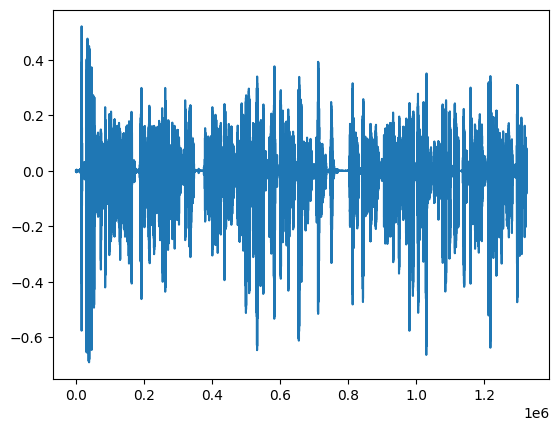

In [5]:
import matplotlib.pyplot as plt
plt.plot(da)

In [6]:
#extract features
mfccs=librosa.feature.mfcc(y=da,sr=sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 2588)


In [7]:
import librosa
def extract_features(filename):
    data, sample_rate=librosa.load(filename)
    mfccs_features=librosa.feature.mfcc(y=data,sr=sample_rate, n_mfcc=30)
    mfccs_scaled=np.mean(mfccs_features.T, axis=0)
    zcr = np.mean(librosa.feature.zero_crossing_rate(data))
    chroma = np.mean(librosa.feature.chroma_stft(y=data, sr=sample_rate))
    contrast = np.mean(librosa.feature.spectral_contrast(y=data, sr=sample_rate))
    full_feature = np.hstack([mfccs_scaled, zcr, chroma, contrast])

    return full_feature

In [8]:
import numpy as np
from tqdm import tqdm

train_path="/kaggle/input/shl-hiring-assessment/Dataset/audios/train"

extracted=[]
for index_num,row in tqdm(train_df.iterrows()):
    fn=os.path.join(os.path.abspath(train_path), str(row['filename']))
    data=extract_features(fn)
    final_label=row['label']
    extracted.append([data, final_label])
    

444it [05:23,  1.37it/s]


In [9]:
df=pd.DataFrame(extracted, columns=['feature','label'])
df.head()

,feature,label
0,"[-358.4134521484375, 97.34856414794922, -21.39...",1.0
1,"[-491.02215576171875, 50.90874481201172, 5.274...",1.0
2,"[-484.9112243652344, 61.28273391723633, -4.729...",1.5
3,"[-429.4405517578125, 32.125301361083984, -4.88...",1.5
4,"[-365.2108154296875, 94.52581787109375, -0.918...",2.0


In [10]:
X=np.array(df.feature.tolist())
X.shape

(444, 33)

In [11]:
y=np.array(df.label.tolist())
y.shape


(444,)

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=42)

In [13]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

In [14]:
#hyperparameters found through randomizedserachcv
xgbmodel=XGBRegressor(subsample=0.8,n_estimators=500, min_child_weight=3,
                     max_depth=5, learning_rate=0.05,gamma=0.1,colsample_bytree=1)

xgbmodel.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0.1, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=3, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [15]:
from sklearn.metrics import mean_squared_error, accuracy_score,mean_absolute_error
y_pred=xgbmodel.predict(X_test)
print("mean_squared_error:", mean_squared_error(y_test,y_pred))
print("mean_abs_error:", mean_absolute_error(y_test,y_pred))

mean_squared_error: 0.7967121654792886
mean_abs_error: 0.7378328676973835


In [16]:
import numpy as np
from tqdm import tqdm

test_path="/kaggle/input/shl-hiring-assessment/Dataset/audios/test"
test_df=pd.read_csv("/kaggle/input/shl-hiring-assessment/Dataset/test.csv")

extracted=[]
for index_num,row in tqdm(test_df.iterrows()):
    fn=os.path.join(os.path.abspath(test_path), str(row['filename']))
    data=extract_features(fn)
    
    extracted.append([data])

204it [02:19,  1.46it/s]


In [17]:
df2=pd.DataFrame(extracted, columns=['feature'])
test_X=np.array(df2.feature.tolist())

final_preds=xgbmodel.predict(test_X)

print(final_preds)

[3.1794124 4.017168  3.2922192 3.09518   2.787956  3.6751125 4.204104
 3.3687546 2.7118444 3.090801  2.786832  2.7850754 3.8247461 2.7477772
 3.8971887 3.0810049 4.071075  3.2759135 2.7513297 3.0407593 3.2572248
 3.7328734 4.1515203 2.081749  4.0195    4.2833066 3.244904  3.3731887
 4.0900116 3.9779472 4.1874475 2.911134  4.112199  3.6315498 4.3092117
 3.8311372 3.166505  3.2950437 4.414579  3.3664582 4.3607817 3.8251648
 3.5924337 3.68562   3.1333232 3.5959332 4.049684  3.8962061 3.947358
 4.3140993 4.6157856 4.056716  3.469872  4.140836  2.850865  4.5381637
 3.8477404 4.316853  3.2480962 4.1747117 3.9446619 3.719353  3.6380394
 4.0840483 4.535129  4.315724  4.008442  4.0214586 3.7883923 4.5815797
 2.966911  3.5363255 3.724176  3.3350801 2.9320815 4.1137056 3.910031
 3.0896814 3.0937276 4.613949  4.2143865 4.4278193 3.046405  3.9363034
 3.842769  3.270388  3.6809907 4.8964562 3.6617248 4.104824  4.010953
 3.2954373 2.9620252 4.2331495 3.9203656 3.592788  3.2307599 3.3075118
 4.4007545

In [18]:
submission=pd.DataFrame({'filename':test_df.filename,'label':final_preds})

In [19]:
submission.to_csv('submission.csv',index=False)
